In [1]:
import pandas as pd
from opponent_analysis.data import Data
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from opponent_analysis.config import Config
import shap
from statsbombpy import sb
%matplotlib inline


2024-01-12 12:46:52.640 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-01-12 12:46:52.643 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-01-12 12:46:52.644 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
data=Data()

In [3]:
df=data.get_data()

2024-01-12 12:46:54.936 
  command:

    streamlit run /Users/borgwardt/Library/Caches/pypoetry/virtualenvs/euro2022-jflC4-0A-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-01-12 12:46:54.937 No runtime found, using MemoryCacheStorageManager
2024-01-12 12:46:54.938 No runtime found, using MemoryCacheStorageManager
credentials were not supplied. open data access only
2024-01-12 12:46:55.608 No runtime found, using MemoryCacheStorageManager
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only

In [9]:
conf = Config()
competitions = sb.competitions()
womens_euro_competition = competitions[
    competitions["competition_name"] == conf.competition_name
]
womens_euro_2022 = womens_euro_competition[
    womens_euro_competition["season_name"] == conf.season_name
]
euro_competition_id = womens_euro_2022.competition_id.unique()[0]
euro_season_id = womens_euro_2022.season_id.unique()[0]
matches = sb.matches(
    competition_id=euro_competition_id, season_id=euro_season_id
)
match_ids = matches[
    matches.match_date < conf.date_of_analysis
].match_id

credentials were not supplied. open data access only


In [10]:
match_ids.unique()

array([3835331, 3835324, 3844384, 3847567, 3845506, 3835335, 3835323,
       3835325, 3835320, 3845507, 3844387, 3844385, 3844386, 3835342,
       3835337, 3835338, 3835330, 3835329, 3835322, 3835332, 3835327,
       3835326, 3835341, 3835340, 3835339, 3835336, 3835334, 3835328,
       3835333, 3835321, 3835319])

In [11]:
match_ids = matches[
    matches.match_date > conf.date_of_analysis
].match_id

In [14]:
match_ids.unique()
matches.match_date
#conf.date_of_analysis

0     2022-07-13
1     2022-07-09
2     2022-07-20
3     2022-07-31
4     2022-07-26
5     2022-07-15
6     2022-07-09
7     2022-07-10
8     2022-07-07
9     2022-07-27
10    2022-07-23
11    2022-07-21
12    2022-07-22
13    2022-07-18
14    2022-07-16
15    2022-07-16
16    2022-07-12
17    2022-07-12
18    2022-07-08
19    2022-07-13
20    2022-07-11
21    2022-07-10
22    2022-07-18
23    2022-07-17
24    2022-07-17
25    2022-07-15
26    2022-07-14
27    2022-07-11
28    2022-07-14
29    2022-07-08
30    2022-07-06
Name: match_date, dtype: object

In [4]:
df.sort_values(["match_id","index"],inplace=True)
halfs=[]
for match_id in df.match_id.unique():
    half="first"
    for index, row in df[df["match_id"]==match_id].iterrows():
        if row["type"]=="Half End":
            half="second"
        halfs.append(half)

In [5]:
df["half"]=halfs

In [6]:
df_half=df.sort_values(["match_id","half","minute"])

In [7]:
df_team=df_half.groupby("match_id").team.unique().apply(pd.Series)
df_team.columns=["home_team","away_team"]

In [8]:
df_half=pd.merge(df_half,df_team,on="match_id",how="left")

In [9]:
df_half["shot_statsbomb_xg"]=df_half.apply(lambda row: row["shot_statsbomb_xg"] if row["team"]==row["home_team"] else -row["shot_statsbomb_xg"],axis=1)

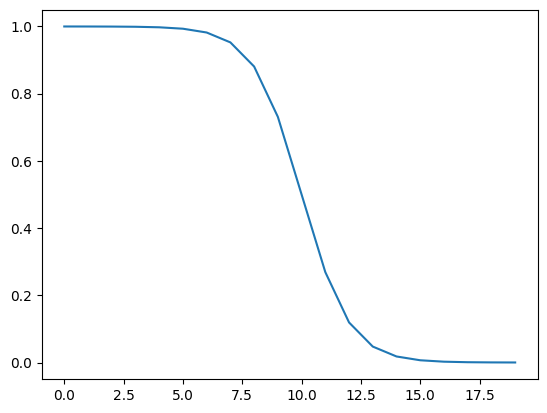

In [10]:
x=np.arange(20)
y=1/(1+np.exp(x-10))
plt.plot(x,y)

In [11]:
temp_columns=[]
for x in np.arange(10):
    temp_column=f"shot_statsbomb_xg_-{x}"
    temp_columns.append(temp_column)
    df_half[temp_column]=df_half[f"shot_statsbomb_xg"].shift(-x)#*1/(1+np.exp(x-10))

In [12]:
df_half["target"]=df_half[temp_columns].sum(axis=1)

In [13]:
df_half.drop(temp_columns,axis=1,inplace=True)

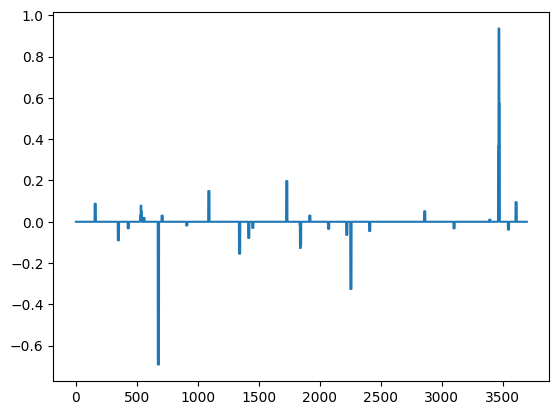

In [14]:
unique_match_ids=df_half.match_id.unique()
unique_match_ids[-1]
plt.plot(df_half[df_half.match_id==unique_match_ids[-1]].target.values)

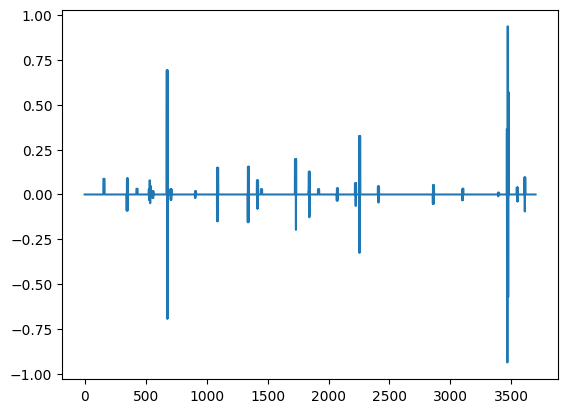

In [15]:
df_half["target_sign_swap"]=df_half.apply(lambda row:row["target"] if row["team"]==row["home_team"] else -row["target"],axis=1)
plt.plot(df_half[df_half.match_id==unique_match_ids[-1]].target_sign_swap.values)

In [16]:
#df_half[df_half.match_id==unique_match_ids[-1]].groupby("player").target_sign_swap.sum().sort_values()


In [17]:
#df_half[df_half.match_id==unique_match_ids[-1]].groupby("player").shot_statsbomb_xg.sum().sort_values()

In [18]:
#[print(x) if "location" in x else 1 for x in df_half.columns.values ]
df_half.columns.values[50:]

array(['pass_height', 'pass_inswinging', 'pass_length', 'pass_outcome',
       'pass_outswinging', 'pass_recipient', 'pass_recipient_id',
       'pass_shot_assist', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'period', 'play_pattern',
       'player', 'player_id', 'position', 'possession', 'possession_team',
       'possession_team_id', 'related_events', 'second',
       'shot_aerial_won', 'shot_body_part', 'shot_deflected',
       'shot_end_location', 'shot_first_time', 'shot_freeze_frame',
       'shot_key_pass_id', 'shot_one_on_one', 'shot_outcome',
       'shot_saved_off_target', 'shot_statsbomb_xg', 'shot_technique',
       'shot_type', 'substitution_outcome', 'substitution_replacement',
       'tactics', 'team', 'team_id', 'timestamp', 'type',
       'under_pressure', 'event_uuid', 'visible_area', 'freeze_frame',
       'ball_recovery_offensive', 'pass_deflected', 'pass_no_touch',
       'pass_straight', 'bad_behaviour_card', 'clearance_other',
     

In [19]:

for feature in ["carry_end_location","goalkeeper_end_location","location","pass_end_location","shot_end_location"]:
    df_temp = df_half[feature].apply(pd.Series)
    df_half[feature+"_x"]=df_temp[0]
    df_half[feature+"_y"]=df_temp[1]

In [42]:

df_ml=df_half.drop(["shot_freeze_frame",'50_50', 'tactics','team_id', 'timestamp',"off_camera","type","target","id","index","shot_statsbomb_xg","home_team","away_team","player_id",'related_events','pass_assisted_shot_id',"pass_recipient_id","possession_team_id","carry_end_location","goalkeeper_end_location","location","pass_end_location","shot_end_location","event_uuid",'visible_area', 'freeze_frame'],axis=1)

In [62]:
train_data = df_ml[(df_ml.match_id!=3847567)].drop(["possession","possession_team","team","match_id","target_sign_swap"],axis=1)

eval_data = df_ml[(df_ml.match_id==3847567)].drop(["possession","possession_team","team","match_id","target_sign_swap"],axis=1)

train_labels = df_ml[df_ml.match_id!=3847567].target_sign_swap

In [63]:
cat_features_indices = np.where(train_data.dtypes == object)[0]

In [64]:
columns=train_data.columns
for i in cat_features_indices:
    train_data[columns[i]]=train_data[columns[i]].fillna("nan")
    eval_data[columns[i]]=eval_data[columns[i]].fillna("nan")

In [65]:

model = CatBoostRegressor(iterations=1000, cat_features=cat_features_indices)
# Fit model
model.fit(train_data, train_labels)
# Get predictions
preds = model.predict(eval_data)

Learning rate set to 0.084952
0:	learn: 0.0526249	total: 128ms	remaining: 2m 7s
1:	learn: 0.0521308	total: 239ms	remaining: 1m 59s
2:	learn: 0.0517047	total: 329ms	remaining: 1m 49s
3:	learn: 0.0513431	total: 419ms	remaining: 1m 44s
4:	learn: 0.0510238	total: 511ms	remaining: 1m 41s
5:	learn: 0.0507516	total: 594ms	remaining: 1m 38s
6:	learn: 0.0505003	total: 680ms	remaining: 1m 36s
7:	learn: 0.0502864	total: 768ms	remaining: 1m 35s
8:	learn: 0.0501042	total: 854ms	remaining: 1m 34s
9:	learn: 0.0499259	total: 943ms	remaining: 1m 33s
10:	learn: 0.0497700	total: 1.04s	remaining: 1m 33s
11:	learn: 0.0496245	total: 1.13s	remaining: 1m 33s
12:	learn: 0.0494958	total: 1.24s	remaining: 1m 34s
13:	learn: 0.0493826	total: 1.34s	remaining: 1m 34s
14:	learn: 0.0492934	total: 1.45s	remaining: 1m 35s
15:	learn: 0.0491993	total: 1.54s	remaining: 1m 34s
16:	learn: 0.0491053	total: 1.63s	remaining: 1m 34s
17:	learn: 0.0490236	total: 1.73s	remaining: 1m 34s
18:	learn: 0.0489468	total: 1.83s	remaining: 

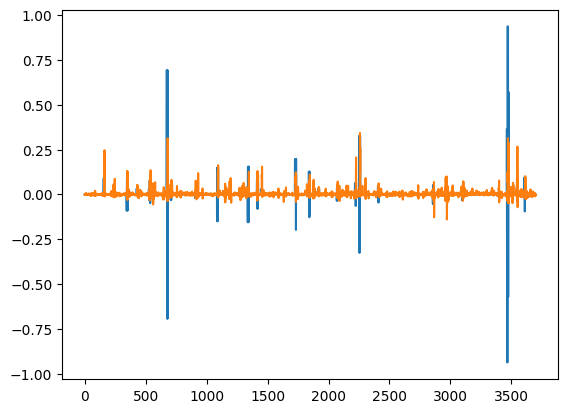

In [66]:

plt.plot(df_ml[(df_ml.match_id==3847567)]["target_sign_swap"].values)
plt.plot(preds)

Text(0.5, 1.0, 'Feature Importance')

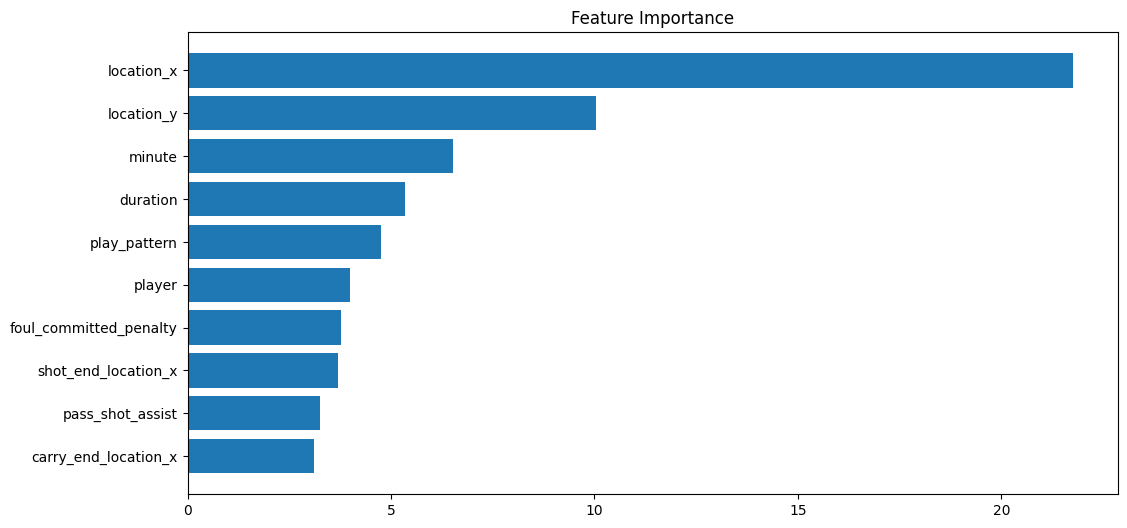

In [67]:
feature_importance = model.feature_importances_#[-10:]
sorted_idx = np.argsort(feature_importance)#[:10]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx))[-10:], feature_importance[sorted_idx][-10:], align='center')
plt.yticks(range(len(sorted_idx))[-10:], np.array(eval_data.columns)[sorted_idx][-10:])
plt.title('Feature Importance')

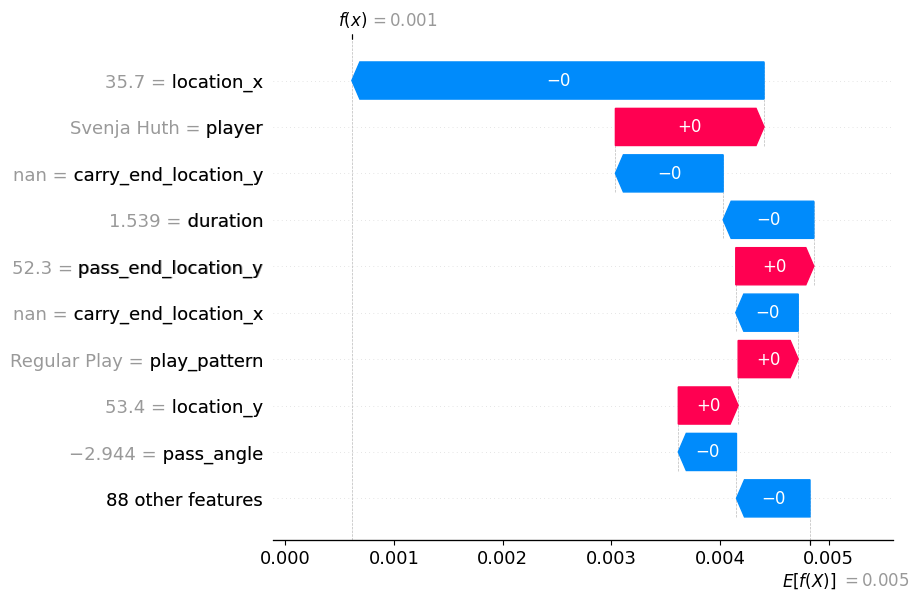

In [89]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer(eval_data)

# visualize the first prediction's explanation

shap.plots.waterfall(shap_values[400])